# Deep VQE
The "Deep VQE" is proposed in the following paper:
https://arxiv.org/abs/2007.10917  
The algorithm used in "Deep VQE" is implemented in this notebook and applied to the toymodel in "Fig.3(a) in the case of N=2".  
The codes are written by "Qulacs"  
If you don't install this module, would you refer to the following page: http://docs.qulacs.org/en/latest/  
I also copied and pasted some codes in the tutorial of VQE section in the above page.

In [1]:
from qulacs import Observable
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import RX, RZ, RY, CNOT, X, Y, Z, CZ
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from qulacs import ParametricQuantumCircuit
from qulacs.gate import Pauli

# Hamiltonian Fig.3 a (N=2)

![hamiltonian(3a,N=2)](./Figures/3a_N2.png)

\begin{align}
\mathcal{H} = \sum^{1}_{i=0}\mathcal{H}_i + \sum_{(i, j)=(2, 4), (0, 6)}V_{ij}
\end{align}

\begin{align}
\mathcal{H}_i &= \sum_{(j, k) \in E}\sum_{A=X,Y,Z}A_{j}A_{k} \\
V_{ij} &= \sum_{A=X,Y,Z}A_{i}A_{j}
\end{align}

Each black sqaure represents each subsystem ($\mathcal{H}_i$) and each black line corresponds to intra-subsystem interactions respectively.   
Red line represents inter-subsystem interaction ($V_{ij}$).  
Considering the symmetry of this system, we have only to calculate one of the subsystems' grand state using VQE.

The number of local bases is $K=7$ because there are 6 inter-subsystem interactions.  
Local bases can be writen using the following forms:  

\begin{align}
\def\ket#1{\mathinner{\left|{#1}\right\rangle}}
\ket{\psi^{(i)}_0}, A^{(i)}_0\ket{\psi^{(i)}_0}, A^{(i)}_2\ket{\psi^{(i)}_0},
\end{align}

The subscript of $A^{(i)}_j$ means the index of qubit applied by this operator.  
($A^{(i)}_j$ is applied to j-th qubit.)

### make_Pauli_string
This function creates "Pauli String" format used when making observable in Qulacs.  
The input data are `op_list` and `var_list`.  
The `op_list` contains indices of operators.  

Indices of operators :  
- 0: Identity Operator
- 1: X
- 2: Y
- 3: Z

`var_list` contains indices of qubits.  

Example: If you want to create "X 0 Y 1" Pauli string, you have to input `op_list = [1, 2], var_list = [0, 1]`.

In [2]:
operator = {}
operator[0] = "I"
operator[1] = "X"
operator[2] = "Y"
operator[3] = "Z"

def make_Pauli_string(op_list, var_list):
    if sum(op_list) == 0:
        Pauli_string = "I 0"
    else:
        Pauli_string = ""
        c = 0
        for i in range(len(var_list)):
            if op_list[i] > 0:
                if c == 0:
                    Pauli_string += "{} {}".format(operator[op_list[i]], var_list[i])
                    c += 1
                else:
                    Pauli_string += " {} {}".format(operator[op_list[i]], var_list[i])
    return Pauli_string

In [3]:
# Example
op_list = [1, 2]
var_list = [0, 1]
make_Pauli_string(op_list, var_list)

'X 0 Y 1'

## Make Observable

In [4]:
n_bits = 4
observable = Observable(n_bits)
coeff = 1
hamiltonian = []
E = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)]
for (i, j) in E:
    for a in range(1, 4):
        var_list = [i, j]
        op_list = [a, a]
        Pauli_string = make_Pauli_string(op_list, var_list)
        print((coeff, Pauli_string))
        hamiltonian.append((coeff, op_list, var_list))
        observable.add_operator(coeff, Pauli_string)

(1, 'X 0 X 1')
(1, 'Y 0 Y 1')
(1, 'Z 0 Z 1')
(1, 'X 1 X 2')
(1, 'Y 1 Y 2')
(1, 'Z 1 Z 2')
(1, 'X 2 X 3')
(1, 'Y 2 Y 3')
(1, 'Z 2 Z 3')
(1, 'X 3 X 0')
(1, 'Y 3 Y 0')
(1, 'Z 3 Z 0')
(1, 'X 0 X 2')
(1, 'Y 0 Y 2')
(1, 'Z 0 Z 2')


These function implemented below are referd to the following page: https://dojo.qulacs.org/ja/latest/notebooks/6.2_qulacs_VQE.html

In [5]:
def cost(phi):
    state = QuantumState(n_bits)
    state.set_zero_state()
    circuit = make_ansatz_circuit(phi, n_bits, E)
    circuit.update_quantum_state(state)
    return observable.get_expectation_value(state)

In [6]:
def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

In [7]:
d = 1 # Depth
def make_ansatz_circuit(phi, n_bits, E, d=d):
    circuit = ParametricQuantumCircuit(n_bits)
    for _ in range(3):
        for (i, j) in E:
            target_list = [i, j]
            for k in range(1, 4):
                pauli_index = [k, k]
                gate = Pauli(target_list, pauli_index)
                circuit.add_gate(gate)
    param_count = 0
    for _ in range(d):
        for (i, j) in E:
            target_list = [i, j]
            for k in range(1, 4):
                pauli_index = [k, k]
                circuit.add_parametric_multi_Pauli_rotation_gate(target_list, pauli_index, phi[param_count])
                param_count += 1
            circuit.add_gate(RX(i, phi[param_count]))
            circuit.add_gate(RX(j, phi[param_count+1]))
            circuit.add_gate(RZ(i, phi[param_count+2]))
            circuit.add_gate(RZ(j, phi[param_count+3]))
            param_count += 4
        for i in range(n_bits//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
            #circuit.add_gate(CNOT(2*i+1, 2*i+2))
        for i in range(n_bits//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
            #circuit.add_gate(CNOT(2*i+1, 2*i+2))
    return circuit

## Optimization
`phi` is optimized and `phi_opt`contains optimized `phi` parameter.

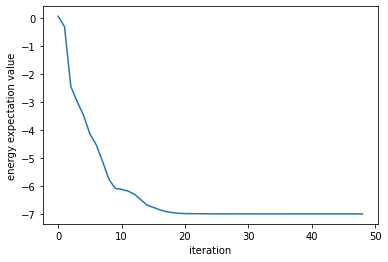

time:0.8934628963470459
VQE Energy: -6.999999999973693


In [8]:
n_params = len(E)*(3+4)*(d)
np.random.seed(1111)
phi = np.random.random(n_params)*2.0*np.pi
#print(phi)
cost_val = []
callback(phi)
start = time.time()
#res = minimize(cost, phi, method='Powell', callback=callback)
res = minimize(cost, phi, method='BFGS', callback=callback)
end = time.time()

plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

phi_opt = res.x
print("time:{}".format(end-start))
print("VQE Energy: {}".format(cost(phi_opt)))

# Make Effective Hamiltonian
We have to measure expectation values of the following operators using $|\psi^{(i)}_0>$: 

\begin{align}
W^{(i)}_k\;\dagger W^{(i)}_l\;, \;\;\; W^{(i)}_k\;\dagger \mathcal{H}^{(i)}W^{(i)}_l, \;\;\; W^{(i)}_k\;\dagger W^{(i)}_{\mu} W^{(i)}_l
\end{align}



### Exchange Operators
We have to contract operators which contain multiple same indices in `var_list` using the exchange rule of Pauli operatos.  
Exmaple: $X_0 Y_0 = i Z_0$  
You have to input `pauli_ex[1, 2] = (i, 3)`.

In [9]:
pauli_ex = {}
pauli_ex[0, 0] = (1, 0)
for i in range(1, 4):
    a = i%3
    b = (i+1)%3
    c = (i+2)%3
    if a == 0:
        a = 3
    if b == 0:
        b = 3
    if c == 0:
        c = 3
    print(a, b, c)
    pauli_ex[a, b] = (0+1j, c)
    pauli_ex[b, a] = (0-1j, c)
    pauli_ex[a, 0] = (1, a)
    pauli_ex[0, a] = (1, a)
    pauli_ex[a, a] = (1, 0)

1 2 3
2 3 1
3 1 2


In [10]:
pauli_ex

{(0, 0): (1, 0),
 (1, 2): (1j, 3),
 (2, 1): (-1j, 3),
 (1, 0): (1, 1),
 (0, 1): (1, 1),
 (1, 1): (1, 0),
 (2, 3): (1j, 1),
 (3, 2): (-1j, 1),
 (2, 0): (1, 2),
 (0, 2): (1, 2),
 (2, 2): (1, 0),
 (3, 1): (1j, 2),
 (1, 3): (-1j, 2),
 (3, 0): (1, 3),
 (0, 3): (1, 3),
 (3, 3): (1, 0)}

In [11]:
# Example
pauli_ex[1, 2]

(1j, 3)

### Constract Operators
Using the above relation, we have to contract all qubit indices in `op_list` and `var_list`.  
Example: $X_0 Y_0 X_1 Z_1 = i*Z_0 * (-i)*Y_1 = 1*Z_0*Y_1$  
`coeff` contains the overall coefficietns.  
`op_list_new` contains indices of operators after contracted.  
`var_list_new` contains indices of qubits after contracted.

In [12]:
def contract_operators(op_list, var_list):
    op_sep = {}
    coeff = 1
    for v in list(set(var_list)):
        op_sep[v] = []
    for i in range(len(op_list)):
        op_sep[var_list[i]].append(op_list[i])
    op_list_new = []
    var_list_new = []
    for v, op in op_sep.items():
        #print(op)
        if len(op) == 1:
            op_list_new.extend(op)
            var_list_new.append(v)
        else:
            while len(op) > 1:
                op1 = op[0]
                op2 = op[1]
                (coeff3, op3) = pauli_ex[op1, op2]
                #print(op1, op2, op3)
                coeff *= coeff3
                op = op[1:]
                op[0] = op3
            op_list_new.extend(op)
            var_list_new.append(v)
    return coeff, op_list_new, var_list_new

In [13]:
op_list = [1, 2, 1, 3]
var_list = [0, 0, 1, 1]
contract_operators(op_list, var_list)

((1+0j), [3, 2], [0, 1])

## Calculate WW, WHW, WVW

In [14]:
K = 7
n_bits = 4
W_op = [0, 1, 2, 3, 1, 2, 3]
W_var = [0, 0, 0, 0, 2, 2, 2]
V_op = [1, 2, 3, 1, 2, 3]
V_var = [0, 0, 0, 2, 2, 2]
WW = np.zeros((K, K)).astype(complex)
WHW = np.zeros((K, K)).astype(complex)
WVW = np.zeros((K-1, K, K)).astype(complex)

# Create Grand State of the subsystem.
state = QuantumState(n_bits)
state.set_zero_state()
circuit = make_ansatz_circuit(phi_opt, n_bits, E)
circuit.update_quantum_state(state)

for i in range(K):
    for j in range(K):
        # WW
        op_list = [W_op[i], W_op[j]]
        var_list = [W_var[i], W_var[j]]
        coeff, op_list, var_list = contract_operators(op_list, var_list)
        Pauli_string = make_Pauli_string(op_list, var_list)
        #print(coeff, Pauli_string)
        obs = Observable(n_bits)
        obs.add_operator(1, Pauli_string)
        WW[i][j] = coeff * obs.get_expectation_value(state)
        
        # WHW
        for (coeff, op_list_h, var_list_h) in hamiltonian:
            op_list = [W_op[i]]
            op_list.extend(op_list_h)
            op_list.append(W_op[j])
            var_list = [W_var[i]]
            var_list.extend(var_list_h)
            var_list.append(W_var[j])
            coeff, op_list, var_list = contract_operators(op_list, var_list)
            Pauli_string = make_Pauli_string(op_list, var_list)
            obs = Observable(n_bits)
            obs.add_operator(1, Pauli_string)
            WHW[i][j] += coeff * obs.get_expectation_value(state)
        
        #WVW
        for k in range(K-1):
            op_list = [W_op[i], V_op[k], W_op[j]]
            var_list = [W_var[i], V_var[k], W_var[j]]
            coeff, op_list, var_list = contract_operators(op_list, var_list)
            Pauli_string = make_Pauli_string(op_list, var_list)
            obs = Observable(n_bits)
            obs.add_operator(1, Pauli_string)
            WVW[k][i][j] = coeff * obs.get_expectation_value(state)

## Make P Matrix  
`P` contains coefficients of $|\psi^{(i)}_k>$.  
Please note that $<\psi^{(i)}_k|\psi^{(i)}_l>\neq \delta_{kl}$.   
So we have to multiply ` WW[k][l]` when calculating inner product.

In [15]:
P = np.zeros((K, K)).astype(complex)
for i in range(K):
    P[i][i] = 1.0
    for j in range(i):
        coeff = 0
        for k in range(K):
            coeff += P[j][k] * WW[k][i]
        #print(i, j, coeff, P[j])
        P[i] -= coeff * P[j]
    C = 0
    for k in range(K):
        for l in range(K):
            C += P[i][k] * P[i][l] * WW[k][l]
    P[i] *= 1.0/np.sqrt(np.abs(C))

Check whether local bases are orthonormalized.

In [16]:
norm = np.zeros((K, K))
for k in range(K):
    for l in range(K):
        n = 0
        for i in range(K):
            for j in range(K):
                n += P[k][i] * P[l][j] * WW[i][j]
        if np.abs(n) <= 1e-5:
            n = 0
        norm[k][l] = np.abs(n)
print(norm)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


## Correspond local bases to qubit states
We have to prepare 3 qubits state.

In [17]:
K = 7
n_bits_new = int(np.ceil(np.log2(K)))
psi = {}
print("Subsystem 0")
for i in range(K):
    psi[i] = format(i, '0{}b'.format(n_bits_new))
    print(i, format(i, '0{}b'.format(n_bits_new)))
print("Subsystem 1")
for i in range(K):
    psi[i+K] = format(i, '0{}b'.format(n_bits_new))
    print(i+K, format(i, '0{}b'.format(n_bits_new)))
#print(psi)

Subsystem 0
0 000
1 001
2 010
3 011
4 100
5 101
6 110
Subsystem 1
7 000
8 001
9 010
10 011
11 100
12 101
13 110


## Correspond projection operators to qubit gates

`get_projection`enables us to do the following transformation:  

$$
\def\bra#1{\mathinner{\left\langle{#1}\right|}}
\begin{align}
\ket{0}\bra{0}_0 &= \frac{1}{2}(I_0 + Z_0) \\
\ket{1}\bra{1}_0 &= \frac{1}{2}(I_0 - Z_0) \\
\ket{0}\bra{1}_0 &= \frac{1}{2}(I_0 - iY_0) \\
\ket{1}\bra{0}_0 &= \frac{1}{2}(I_0 + iY_0)
\end{align}
$$

`coeff_op_list` contains each coefficients and indices of operators respectively.

In [18]:
def get_projection(i, j, sub_idx=0):
    # | i >|< j | _{bit} 
    op_list = []
    coeff_op_list = []
    if (i, j) == (0, 0):
        coeff_op_list.append((0.5, 0)) #0.5 * I
        coeff_op_list.append((0.5, 3)) # 0.5 * Z
    elif (i, j) == (1, 1):
        coeff_op_list.append((0.5, 0)) # 0.5 * I
        coeff_op_list.append((-0.5, 3)) # -0.5 * Z
    elif (i, j) == (0, 1):
        coeff_op_list.append((0.5, 1)) # 0.5 * X
        coeff_op_list.append((0.5j, 2)) # -0.5 * XZ = 0.5i * Y
    elif (i, j) == (1, 0):
        coeff_op_list.append((0.5, 1)) # 0.5 * X
        coeff_op_list.append((-0.5j, 2)) # 0.5 * XZ = -0.5i * Y
    return coeff_op_list

In [19]:
# Example
get_projection(0, 1)

[(0.5, 1), (0.5j, 2)]

`get_local_basis_operator` can transform multiple qubit projection operators to qubit gate.  
(I'm sorry but, this coed can be applied to only 3 qubit state.)

Example: 

$$
\def\bra#1{\mathinner{\left\langle{#1}\right|}}
\begin{align}
    \ket{\tilde{\psi}^{(i)}_1} \bra{\tilde{\psi}^{(i)}_2} &= \ket{000}\bra{001}\\
    &= \frac{1}{8} [I_0, Z_0] \cdot [I_1, Z_1] \cdot [X_2, -X_2Z_2] \\
    &= \frac{1}{8} [I_0I_1, Z_1, Z_0, Z_0Z_1]\cdot [X_2, -X_2Z_2] \\
    &= \frac{1}{8} [X_2, -X_2Z_2, Z_1X_2, -Z_1X_2Z_2, Z_0X_2, -Z_0X_2Z_2, Z_0Z_1X_2, -Z_0Z_1X_2Z_2] \\
    &= \frac{1}{8} [X_2, iY_2, Z_1X_2, iZ_1Y_2, Z_0X_2, iZ_0Y_2, Z_0Z_1X_2, iZ_0Z_1Y_2]
\end{align}
$$

If you input `psi1`to `psi[0]` and `psi2` to `psi[1]`, `res` containing the above coefficietns and indices of operators will be returned.

In [20]:
def get_local_basis_operator(psi1, psi2, K=7, sub_idx=0):
    bit_num = int(np.ceil(np.log2(K)))
    coeff_op_list = []
    for i in range(bit_num):
        coeff_op_list_temp = get_projection(int(psi1[i]), int(psi2[i]), sub_idx)
        coeff_op_list.append(coeff_op_list_temp)
    res = []
    for i in range(2):
        for j in range(2):
            for k in range(2):
                #coeff = op_list[0][i][0] * op_list[1][j][0] * op_list[2][k][0]
                #op = op_list[0][i][1] + " " +  op_list[1][j][1] + " " +  op_list[2][k][1]
                coeff = coeff_op_list[0][i][0] * coeff_op_list[1][j][0] * coeff_op_list[2][k][0]
                op = [coeff_op_list[0][i][1], coeff_op_list[1][j][1],  coeff_op_list[2][k][1]]
                res.append((coeff, op))
    return res

In [21]:
# Example
get_local_basis_operator(psi[0], psi[1])

[(0.125, [0, 0, 1]),
 (0.125j, [0, 0, 2]),
 (0.125, [0, 3, 1]),
 (0.125j, [0, 3, 2]),
 (0.125, [3, 0, 1]),
 (0.125j, [3, 0, 2]),
 (0.125, [3, 3, 1]),
 (0.125j, [3, 3, 2])]

## Make Effective Subsystem Hamiltonian

`ham_eff` is a dict data.  
The key of `ham_eff` is (`op_list`, `var_list`) and corresponding coefficient is assigned to the value of its key.  
Example: If you want to know the coefficient of $Z_0X_1Y_2$, you refer to `ham_eff[(3, 1, 2), (0, 1, 2)]`.

In [22]:
def make_H_eff_i(WHW, P, K, ham_eff, num_sub=2):
    H_eff_i = np.dot(P.conjugate(), np.dot(WHW, P.T))
    for sub_idx in range(num_sub):
        for k in range(K):
            for l in range(K):
                coeff_op_list = get_local_basis_operator(psi[k], psi[l], K, sub_idx)
                for coeff, op_list in coeff_op_list:
                    op0 = op_list[0]
                    op1 = op_list[1]
                    op2 = op_list[2]
                    if sub_idx == 0:
                        var = (0, 1, 2)
                    else:
                        var = (3, 4, 5)
                    op_idx = (op0, op1, op2)
                    idx = (op_idx, var)
                    if idx not in ham_eff.keys():
                         ham_eff[idx] = H_eff_i[k][l]*coeff
                    else:
                        ham_eff[idx] += H_eff_i[k][l]*coeff
    return ham_eff
ham_eff = {}
ham_eff = make_H_eff_i(WHW, P, K, ham_eff)

In [23]:
# Example
ham_eff[(3, 1, 2), (0, 1, 2)]

(-1.3827851425130078e-07-4.642283924125855e-18j)

## Make Effective Interaction Hamiltonian 
`v_eff` is also a dict data.  
The key of `v_eff` is `op_list` and corresponding coefficient is assigned to the value of its key.  
Example: If you want to know the coefficient of $Z_0Z_1Z_2X_4Y_5$, you refer to `v_eff[3, 3, 3, 0, 1, 2]`.

In [24]:
def make_V_eff(WVW, P, K, v_eff):
    WVW_ = np.zeros((K-1, K, K)).astype(complex)
    for k in range(K-1):
        WVW_[k] = np.dot(P.conjugate(), np.dot(WVW[k], P.T))
    V_eff = np.zeros((K, K, K, K)).astype(complex)
    for i in range(K):
        for j in range(K):
            coeff_op_list1 = get_local_basis_operator(psi[i], psi[j], K, 0)
            for k in range(K):
                for l in range(K):
                    coeff_op_list2 = get_local_basis_operator(psi[k+K], psi[l+K], K, 1)
                    coeff = 0
                    for m in range(K//2):
                        coeff += WVW_[m][i][j] * WVW_[m+K//2][k][l]
                        #coeff += WVW_[m+K//2][i][j] * WVW_[m][k][l]
                    for (coeff1, op_list1) in coeff_op_list1:
                        for (coeff2, op_list2) in coeff_op_list2:
                            coeff_ = coeff*coeff1*coeff2
                            op0 = op_list1[0]
                            op1 = op_list1[1]
                            op2 = op_list1[2]
                            op3 = op_list2[0]
                            op4 = op_list2[1]
                            op5 = op_list2[2]
                            op_idx = (op0, op1, op2, op3, op4, op5)
                            if op_idx not in v_eff.keys():
                                v_eff[op_idx] = coeff_
                            else:
                                v_eff[op_idx] += coeff_   
                    V_eff[i][j][k][l] = coeff
    return v_eff, V_eff, WVW_
v_eff = {}
v_eff, V_eff, WVW_ = make_V_eff(WVW, P, K, v_eff)
for op, coeff in v_eff.items():
    if coeff.imag > 1e-6:
        print(op, coeff)

In [25]:
# Example
v_eff[3, 3, 3, 0, 1, 2]

(-6.802607936567988e-08+6.254707723541875e-24j)

## Make Observable

In [26]:
n_bits = int(np.ceil(np.log2(K))) * 2
observable = Observable(n_bits)
for (op_list, var_list), coeff in ham_eff.items():
    Pauli_string = make_Pauli_string(op_list, var_list)
    observable.add_operator(coeff.real, Pauli_string)
var_list = [i for i in range(n_bits)]
for op_list, coeff in v_eff.items():
    Pauli_string = make_Pauli_string(op_list, var_list)
    observable.add_operator(coeff.real, Pauli_string)

In [27]:
def cost(phi):
    state = QuantumState(n_bits)
    state.set_zero_state()
    circuit = make_ansatz_circuit(phi, n_bits, E)
    circuit.update_quantum_state(state)
    return observable.get_expectation_value(state)

In [28]:
E = []
for i in range(n_bits):
    for j in range(i):
        #print((i, j))
        E.append((i, j))
d = 1 # Depth
def make_ansatz_circuit(phi, n_bits, E, d=d):
    circuit = ParametricQuantumCircuit(n_bits)
    for _ in range(3):
        for (i, j) in E:
            target_list = [i, j]
            for k in range(1, 4):
                pauli_index = [k, k]
                gate = Pauli(target_list, pauli_index)
                circuit.add_gate(gate)
    param_count = 0
    for _ in range(d):
        for (i, j) in E:
            target_list = [i, j]
            for k in range(1, 4):
                pauli_index = [k, k]
                circuit.add_parametric_multi_Pauli_rotation_gate(target_list, pauli_index, phi[param_count])
                param_count += 1
            circuit.add_gate(RX(i, phi[param_count]))
            circuit.add_gate(RX(j, phi[param_count+1]))
            circuit.add_gate(RZ(i, phi[param_count+2]))
            circuit.add_gate(RZ(j, phi[param_count+3]))
            param_count += 4
        for i in range(n_bits//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
            #circuit.add_gate(CNOT(2*i+1, 2*i+2))
        for i in range(n_bits//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
            #circuit.add_gate(CNOT(2*i+1, 2*i+2))
    return circuit

## Optimization

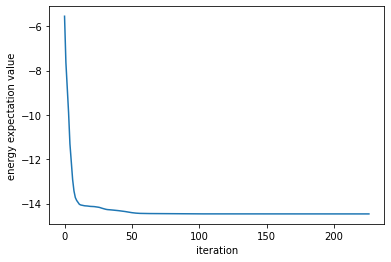

Time:359.68108558654785
VQE Energy: -14.464101608625086


In [29]:
n_params = len(E) * (3 + 4) * d
np.random.seed(1111)
cost_val = []
phi = np.random.random(n_params)*2.0*np.pi
#print(phi)
callback(phi)
start = time.time()
#res = minimize(cost, phi, method='Powell', callback=callback)
res = minimize(cost, phi, method='BFGS', callback=callback)
end = time.time()

plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

phi_opt_new = res.x
print("Time:{}".format(end-start))
print("VQE Energy: {}".format(cost(phi_opt_new)))

# Verification
By diagonalizing the total effective hamiltonian, we can validate the result of "Deep VQE".  

In [32]:
local_basis = [(i, j) for i in range(K) for j in range(K)]
H_eff_i = np.dot(P, np.dot(WHW, P.T))
H_eff = np.zeros((K*K, K*K)).astype(complex)
for i in range(K*K):
    for j in range(K*K):
        (k, l) = local_basis[i]
        (m, n) = local_basis[j]
        delta1 = (k==m)
        delta2 = (l==n)
        H_eff[i, j] = H_eff_i[k, m]*delta2 + H_eff_i[l, n]*delta1  + V_eff[k][m][l][n]

In [33]:
np.min(np.linalg.eig(H_eff)[0])

(-14.464101615114265+1.188181582338849e-13j)